In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import f1_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from imblearn.combine import SMOTETomek

In [4]:
# Load datasets
train_df = pd.read_csv('./data/train.csv')
test_df = pd.read_csv('./data/test.csv')

# Display the first few rows
print("First few rows of the training data:")
print(train_df.head())

# Align training and test datasets
train_df, test_df = train_df.align(test_df, join='left', axis=1, fill_value=0)
# Check dataset shapes
print(f"\nTraining data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")

First few rows of the training data:
        id                         trans_num  trans_date trans_time  \
0   308467  26ad750c2ff71f32631b58913582d70a  2024-01-10   06:49:39   
1   261578  fea9c1efe3f2b97f27ad0ab5409ec861  2024-01-06   02:37:50   
2      341  2ae350b982be840f3666273e0c2f3a05  2024-01-18   21:40:21   
3  1147639  bbdd8adfc0a34ed0e817f809193c85c0  2024-01-21   16:20:15   
4   314152  fc7756004dc2a9bc450eb894a670b804  2024-01-21   19:36:26   

    unix_time        category     amt            cc_num    first     last  \
0  1704887379        misc_pos  188.38      676355457570   Andrea  Johnson   
1  1704526670     grocery_pos  102.63   377178373574671   Rhonda   Chavez   
2  1705632021   entertainment    1.62  3599292013370451  Stephen     Khan   
3  1705872015  health_fitness    5.64  3594292572430345   Justin   Reilly   
4  1705883786  health_fitness   97.09  4867547663675548    Alice   Duarte   

   ...    zip      lat      long city_pop                          job  \

In [5]:
# Feature Engineering
def haversine_distance(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    c = 2 * np.arcsin(np.sqrt(a)) 
    r = 6371  # Radius of Earth in kilometers
    return c * r

# Calculate haversine distance
train_df['distance'] = haversine_distance(train_df['lat'], train_df['long'],
                                          train_df['merch_lat'], train_df['merch_long'])
test_df['distance'] = haversine_distance(test_df['lat'], test_df['long'],
                                         test_df['merch_lat'], test_df['merch_long'])


# Combine 'trans_date' and 'trans_time' into 'trans_datetime'
train_df['trans_datetime'] = pd.to_datetime(train_df['trans_date'] + ' ' + train_df['trans_time'])
test_df['trans_datetime'] = pd.to_datetime(test_df['trans_date'] + ' ' + test_df['trans_time'])

# Extract time-based features
for df in [train_df, test_df]:
    df['transaction_hour'] = df['trans_datetime'].dt.hour
    df['transaction_day'] = df['trans_datetime'].dt.day
    df['transaction_month'] = df['trans_datetime'].dt.month
    df['transaction_year'] = df['trans_datetime'].dt.year
    df['transaction_dayofweek'] = df['trans_datetime'].dt.dayofweek

# Calculate age
train_df['dob'] = pd.to_datetime(train_df['dob'])
test_df['dob'] = pd.to_datetime(test_df['dob'])
train_df['age'] = (train_df['trans_datetime'] - train_df['dob']).dt.days / 365
test_df['age'] = (test_df['trans_datetime'] - test_df['dob']).dt.days / 365
# High-Risk Categories
high_risk_categories = train_df.groupby('category')['is_fraud'].mean()
train_df['category_risk'] = train_df['category'].map(high_risk_categories)
test_df['category_risk'] = test_df['category'].map(high_risk_categories).fillna(0)
# Demographics Risk Factor
demographics_risk = train_df.groupby(['state', 'gender'])['is_fraud'].mean()
train_df['demographics_risk'] = train_df.apply(lambda x: demographics_risk.get((x['state'], x['gender']), 0), axis=1)
test_df['demographics_risk'] = test_df.apply(lambda x: demographics_risk.get((x['state'], x['gender']), 0), axis=1)
# Transaction Timing Patterns
train_df['is_weekend'] = train_df['transaction_dayofweek'].isin([5, 6]).astype(int)
test_df['is_weekend'] = test_df['transaction_dayofweek'].isin([5, 6]).astype(int)
# Fraud History
train_df['fraud_count_per_cc'] = train_df.groupby('cc_num')['is_fraud'].cumsum()
test_df['fraud_count_per_cc'] = test_df.groupby('cc_num')['is_fraud'].cumsum()
# Feature Engineering: Transaction Recency & Frequency
train_df['prev_trans_time'] = train_df.groupby('cc_num')['unix_time'].shift(1)
train_df['time_since_last_trans'] = train_df['unix_time'] - train_df['prev_trans_time']
train_df['time_since_last_trans'].fillna(train_df['time_since_last_trans'].mean(), inplace=True)


# Transaction Rolling Statistics for train_df
rolling_stats = train_df.groupby('cc_num')['amt'].rolling(window=3, min_periods=1).agg(['mean', 'std']).reset_index()
rolling_stats.rename(columns={'level_1': 'rolling_idx'}, inplace=True)  # Correctly rename the index
rolling_stats.columns = ['cc_num', 'rolling_idx', 'amt_mean_3', 'amt_std_3']  # Rename other columns explicitly

# Ensure 'rolling_idx' column exists for merging
train_df = train_df.reset_index(drop=True)  # Reset the main DataFrame index to be consistent
rolling_stats['rolling_idx'] = rolling_stats['rolling_idx'].astype(int)  # Ensure proper data type for merging
train_df['rolling_idx'] = train_df.index  # Match the rolling_idx for merge

# Merge the rolling stats back into train_df
train_df = train_df.merge(rolling_stats, on=['cc_num', 'rolling_idx'], how='left')

# Transaction Rolling Statistics for test_df
rolling_stats_test = test_df.groupby('cc_num')['amt'].rolling(window=3, min_periods=1).agg(['mean', 'std']).reset_index()
rolling_stats_test.rename(columns={'level_1': 'rolling_idx'}, inplace=True)
rolling_stats_test.columns = ['cc_num', 'rolling_idx', 'amt_mean_3', 'amt_std_3']

# Ensure 'rolling_idx' column exists for merging in test_df
test_df = test_df.reset_index(drop=True)
rolling_stats_test['rolling_idx'] = rolling_stats_test['rolling_idx'].astype(int)
test_df['rolling_idx'] = test_df.index  # Match rolling_idx for merge

# Merge the rolling stats back into test_df
test_df = test_df.merge(rolling_stats_test, on=['cc_num', 'rolling_idx'], how='left')

test_df['prev_trans_time'] = test_df.groupby('cc_num')['unix_time'].shift(1)
test_df['time_since_last_trans'] = test_df['unix_time'] - test_df['prev_trans_time']
test_df['time_since_last_trans'].fillna(train_df['time_since_last_trans'].mean(), inplace=True)
# Merchant Popularity
merchant_popularity = train_df['merchant'].value_counts()
train_df['merchant_popularity'] = train_df['merchant'].map(merchant_popularity)
test_df['merchant_popularity'] = test_df['merchant'].map(merchant_popularity).fillna(0)

# Label Encoding
le = LabelEncoder()
train_df['gender'] = le.fit_transform(train_df['gender'])
test_df['gender'] = le.transform(test_df['gender'])
# Age Buckets
train_df['age_bucket'] = pd.cut(train_df['age'], bins=[0, 20, 40, 60, 100], labels=['<20', '20-40', '40-60', '>60'])
test_df['age_bucket'] = pd.cut(test_df['age'], bins=[0, 20, 40, 60, 100], labels=['<20', '20-40', '40-60', '>60'])
# Population Density Risk
train_df['pop_density_risk'] = pd.cut(train_df['city_pop'], bins=[0, 1000, 10000, 100000, 1000000],
                                      labels=['Rural', 'Suburban', 'Urban', 'Metropolitan'])
test_df['pop_density_risk'] = pd.cut(test_df['city_pop'], bins=[0, 1000, 10000, 100000, 1000000],
                                     labels=['Rural', 'Suburban', 'Urban', 'Metropolitan'])
# Calculate fraud rate for each job
job_fraud_rate = train_df.groupby('job')['is_fraud'].mean().sort_values(ascending=False)

# Map fraud rate as a new feature
train_df['job_risk_score'] = train_df['job'].map(job_fraud_rate)
test_df['job_risk_score'] = test_df['job'].map(job_fraud_rate)

# Handle jobs in test set not seen in the training set
test_df['job_risk_score'] = test_df['job_risk_score'].fillna(0)


# --- 1. Fraud Risk Score for City, State, and Zip ---
# Calculate fraud rates
city_fraud_rate = train_df.groupby('city')['is_fraud'].mean()
state_fraud_rate = train_df.groupby('state')['is_fraud'].mean()
zip_fraud_rate = train_df.groupby('zip')['is_fraud'].mean()

# Map fraud risk scores to training and test data
train_df['city_risk_score'] = train_df['city'].map(city_fraud_rate)
train_df['state_risk_score'] = train_df['state'].map(state_fraud_rate)
train_df['zip_risk_score'] = train_df['zip'].map(zip_fraud_rate)

test_df['city_risk_score'] = test_df['city'].map(city_fraud_rate).fillna(0)
test_df['state_risk_score'] = test_df['state'].map(state_fraud_rate).fillna(0)
test_df['zip_risk_score'] = test_df['zip'].map(zip_fraud_rate).fillna(0)

# --- 2. One-Hot Encoding for Top Cities and States ---
# Identify top cities and states
top_cities = train_df['city'].value_counts().head(10).index
top_states = train_df['state'].value_counts().head(10).index

# Create binary features for top cities and states
train_df['top_city'] = train_df['city'].apply(lambda x: 1 if x in top_cities else 0)
train_df['top_state'] = train_df['state'].apply(lambda x: 1 if x in top_states else 0)

test_df['top_city'] = test_df['city'].apply(lambda x: 1 if x in top_cities else 0)
test_df['top_state'] = test_df['state'].apply(lambda x: 1 if x in top_states else 0)

# --- 3. Zip Code Simplification ---
# Extract first 3 digits of the zip code
train_df['zip_prefix'] = train_df['zip'].astype(str).str[:3]
test_df['zip_prefix'] = test_df['zip'].astype(str).str[:3]

# Map fraud rate based on zip_prefix
zip_prefix_fraud_rate = train_df.groupby('zip_prefix')['is_fraud'].mean()
train_df['zip_prefix_risk_score'] = train_df['zip_prefix'].map(zip_prefix_fraud_rate)
test_df['zip_prefix_risk_score'] = test_df['zip_prefix'].map(zip_prefix_fraud_rate).fillna(0)
# --- 1. Fraud Risk Score for Merchant ---
# Calculate fraud rates for merchants
merchant_fraud_rate = train_df.groupby('merchant')['is_fraud'].mean()

# Map fraud risk scores to training and test data
train_df['merchant_risk_score'] = train_df['merchant'].map(merchant_fraud_rate)
test_df['merchant_risk_score'] = test_df['merchant'].map(merchant_fraud_rate)

# Handle merchants in the test set not seen in the training set
test_df['merchant_risk_score'] = test_df['merchant_risk_score'].fillna(0)

# --- 2. Transaction Volume for Merchants ---
# Calculate the number of transactions for each merchant
merchant_transaction_count = train_df['merchant'].value_counts()

# Map transaction volume to training and test data
train_df['merchant_transaction_count'] = train_df['merchant'].map(merchant_transaction_count)
test_df['merchant_transaction_count'] = test_df['merchant'].map(merchant_transaction_count).fillna(0)

# --- 3. Top Risky Merchants ---
# Identify top 10 merchants by fraud risk
top_risky_merchants = merchant_fraud_rate.sort_values(ascending=False).head(10).index

# Create a binary feature for top risky merchants
train_df['is_top_risky_merchant'] = train_df['merchant'].apply(lambda x: 1 if x in top_risky_merchants else 0)
test_df['is_top_risky_merchant'] = test_df['merchant'].apply(lambda x: 1 if x in top_risky_merchants else 0)

# --- 1. Transaction Count per Card ---
transaction_count = train_df['cc_num'].value_counts()

train_df['cc_transaction_count'] = train_df['cc_num'].map(transaction_count)
test_df['cc_transaction_count'] = test_df['cc_num'].map(transaction_count).fillna(0)

# --- 2. Fraud Count and Fraud Rate per Card ---
fraud_count = train_df[train_df['is_fraud'] == 1].groupby('cc_num').size()
fraud_rate = fraud_count / transaction_count

train_df['cc_fraud_count'] = train_df['cc_num'].map(fraud_count).fillna(0)
train_df['cc_fraud_rate'] = train_df['cc_num'].map(fraud_rate).fillna(0)

test_df['cc_fraud_count'] = test_df['cc_num'].map(fraud_count).fillna(0)
test_df['cc_fraud_rate'] = test_df['cc_num'].map(fraud_rate).fillna(0)

# --- 3. Average Transaction Amount per Card ---
avg_transaction_amt = train_df.groupby('cc_num')['amt'].mean()

train_df['cc_avg_transaction_amt'] = train_df['cc_num'].map(avg_transaction_amt)
test_df['cc_avg_transaction_amt'] = test_df['cc_num'].map(avg_transaction_amt).fillna(train_df['amt'].mean())

# --- 4. Time Since Last Transaction ---
train_df = train_df.sort_values(['cc_num', 'unix_time'])
train_df['cc_time_since_last_trans'] = train_df.groupby('cc_num')['unix_time'].diff().fillna(0)

test_df = test_df.sort_values(['cc_num', 'unix_time'])
test_df['cc_time_since_last_trans'] = test_df.groupby('cc_num')['unix_time'].diff().fillna(0)

# --- 5. High-Risk Cards ---
high_risk_threshold = 0.2  # Example threshold (20% fraud rate)
train_df['is_high_risk_card'] = (train_df['cc_fraud_rate'] > high_risk_threshold).astype(int)
test_df['is_high_risk_card'] = (test_df['cc_fraud_rate'] > high_risk_threshold).astype(int)

# Identify categorical columns
categorical_columns = ['pop_density_risk', 'category', 'state', 'age_bucket']

# One-hot encode categorical columns
train_df = pd.get_dummies(train_df, columns=categorical_columns, drop_first=True)
test_df = pd.get_dummies(test_df, columns=categorical_columns, drop_first=True)



C:\Users\jason\AppData\Local\Temp\ipykernel_11972\1635760263.py:52: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df['time_since_last_trans'].fillna(train_df['time_since_last_trans'].mean(), inplace=True)
C:\Users\jason\AppData\Local\Temp\ipykernel_11972\1635760263.py:83: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are

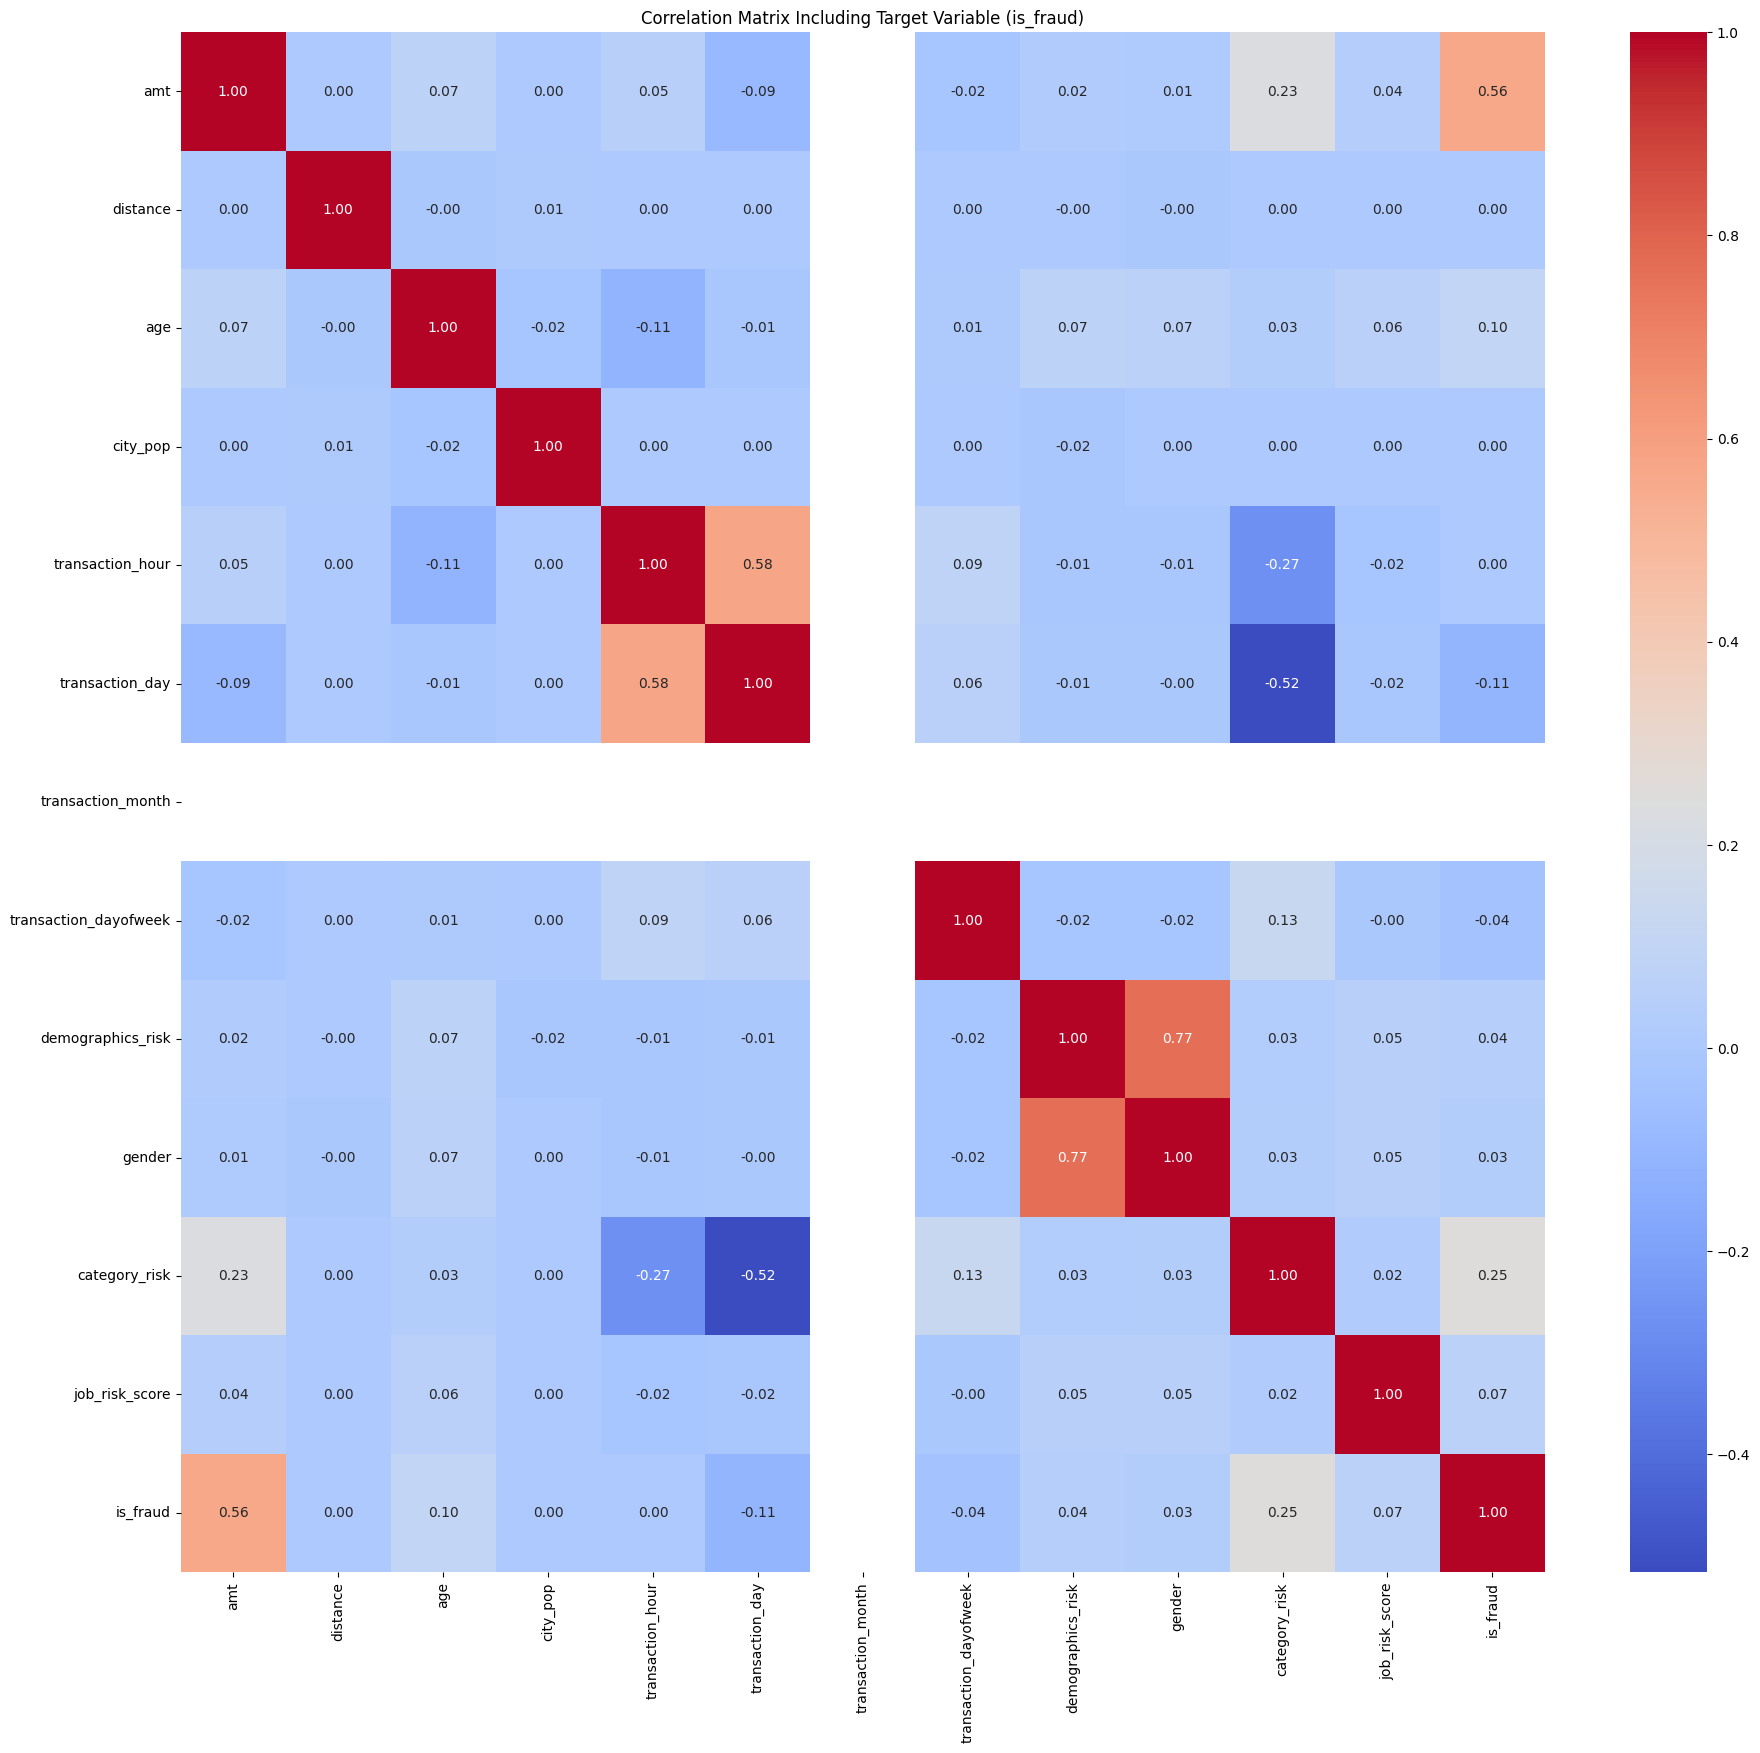

In [ ]:

# Handle missing features after one-hot encoding
train_df, test_df = train_df.align(test_df, join='left', axis=1, fill_value=0)
# Manual Feature Selection
selected_features = [
     'amt','distance', 'age', 'city_pop', 'transaction_hour',
    'transaction_day','transaction_month', 'transaction_dayofweek', 'demographics_risk',
    'gender', 'category_risk','job_risk_score','zip_risk_score','merchant_transaction_count','cc_time_since_last_trans'
] #+ [col for col in train_df.columns if col.startswith(tuple(categorical_columns))]
# Add or remove features here manually
correlation_data = train_df[selected_features + ['is_fraud']]
# Compute the correlation matrix
correlation_matrix = correlation_data.corr()

# Plot the heatmap
plt.figure(figsize=(22, 20))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix Including Target Variable (is_fraud)")
plt.show()

In [13]:
# Separate features and target variable
X = train_df[selected_features]
y = train_df['is_fraud']
X_test = test_df[selected_features]

# Standardize numeric features
#scaler = StandardScaler()
#X = scaler.fit_transform(X)
#X_test = scaler.transform(X_test)


In [14]:
# Model Training

xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
lr_clf = LogisticRegression()
voting_clf = VotingClassifier(estimators=[
    ('xgb', xgb_clf),
    ('rf', rf_clf),
    ('lr', lr_clf)
], voting='soft')


In [15]:
# Evaluate on validation set
X_train_orig, X_valid_orig, y_train_orig, y_valid_orig = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)
# Apply SMOTE to the training data only
#smote_tomek = SMOTETomek(random_state=42)
#X_resampled, y_resampled = smote_tomek.fit_resample(X_train_orig, y_train_orig)


xgb_clf.fit(X_train_orig, y_train_orig)
y_pred = xgb_clf.predict(X_valid_orig)
#voting_clf.fit(X_train_orig, y_train_orig)
#y_pred = voting_clf.predict(X_valid_orig)
print("\nClassification Report on Validation Set:")
print(classification_report(y_valid_orig, y_pred))
print(f"F1 Score on Validation Set: {f1_score(y_valid_orig, y_pred)}")

c:\Users\jason\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:158: UserWarning: [20:00:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Classification Report on Validation Set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     65681
           1       0.99      0.97      0.98      8460

    accuracy                           0.99     74141
   macro avg       0.99      0.98      0.99     74141
weighted avg       0.99      0.99      0.99     74141

F1 Score on Validation Set: 0.9778229421961863


In [16]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, f1_score, classification_report

# Features and target variable
X = train_df[selected_features]
y = train_df['is_fraud']

# Initialize the Stratified K-Fold cross-validator
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Store scores
train_roc_auc = []
val_roc_auc = []
train_f1 = []
val_f1 = []

# Cross-validation
for train_idx, val_idx in cv.split(X, y):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    # Initialize the model (replace with your model, e.g., XGBoost, RandomForest)
    from xgboost import XGBClassifier
    model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Predict probabilities and classes
    y_train_pred_proba = model.predict_proba(X_train)[:, 1]
    y_val_pred_proba = model.predict_proba(X_val)[:, 1]
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    
    # Calculate metrics
    train_roc_auc.append(roc_auc_score(y_train, y_train_pred_proba))
    val_roc_auc.append(roc_auc_score(y_val, y_val_pred_proba))
    train_f1.append(f1_score(y_train, y_train_pred))
    val_f1.append(f1_score(y_val, y_val_pred))

# Print mean and standard deviation of metrics
print("ROC AUC Score:")
print(f"Train: {np.mean(train_roc_auc):.4f} ± {np.std(train_roc_auc):.4f}")
print(f"Validation: {np.mean(val_roc_auc):.4f} ± {np.std(val_roc_auc):.4f}")
print("\nF1 Score:")
print(f"Train: {np.mean(train_f1):.4f} ± {np.std(train_f1):.4f}")
print(f"Validation: {np.mean(val_f1):.4f} ± {np.std(val_f1):.4f}")

c:\Users\jason\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:158: UserWarning: [20:00:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\jason\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:158: UserWarning: [20:00:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\jason\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:158: UserWarning: [20:00:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

ROC AUC Score:
Train: 0.9998 ± 0.0000
Validation: 0.9995 ± 0.0001

F1 Score:
Train: 0.9864 ± 0.0004
Validation: 0.9774 ± 0.0024


In [17]:
# Predict on the test set
#test_preds = xgb_clf.predict(X_test)
test_preds = xgb_clf.predict(X_test)
submission = pd.DataFrame({'id': test_df['id'], 'is_fraud': test_preds})
submission.to_csv('submission.csv', index=False)
print("\nSubmission file 'submission.csv' created.")


Submission file 'submission.csv' created.
